# Data preproccessing and classifier implementation 

In this notebook, data will be preprocessed and output as csv files to be used in the notebooks afterwards.
A classifier is then fitted from data split into test and training sets.

For the processes to run, 2 new folders need to be generated "data" and "data_removed" nested in "data".
This allows all the data to be preprocessed in one cell and be called from the other cells.

In [22]:
# import packages
%matplotlib nbagg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.widgets
import seaborn as sns

from tkinter import * 
import tkinter.messagebox 

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import RadioButtons
from sklearn import svm
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                     StratifiedKFold, GroupShuffleSplit,
                                     GroupKFold, StratifiedShuffleSplit)

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator


Some packages are not used, as the entire code is complied in 1 notebook. This is acceptable as it doesn't take too long to load.

# Preproccessor class

A class is made to preprocess data so these lines do not need to be call multiple times.

In [3]:
# class to preprocess data

class Preprocessor:
    
    # initalise self with data needed to be preproccessed
    def __init__ (self, data):
        self.data = data

    def encode(self, kind: str, c_name):

        # update self.data with the appropriate encoder
        assert kind in ['onehot', 'label']
        self.kind = kind
          
        # do one hot encoder
        if self.kind == 'onehot':
            classes = set(self.data[c_name])
            for cls in classes:
                self.data[cls] = self.data[c_name].apply(lambda x: 1 if x == cls else 0)
            del self.data[c_name]
            return self.data
            
        # do label encoder
        else:
            classes = set(self.data[c_name])
            values = {list(classes)[i]: i for i in range(len(classes))}
            self.data[c_name] = self.data[c_name].apply(lambda x: values[x])

        return self.data
    
    def scaler(self, kind: str, c_name):
        
        # update self.data with the appropriate scaler
        
         # make sure kind is either minmax or standard
        assert kind in ['minmax', 'standard']

        # start with minmax
        if kind == 'minmax':
            min_value = min(self.data[c_name])
            max_value = max(self.data[c_name])
            diff = max_value - min_value
            self.data[c_name] = self.data[c_name].apply(lambda x: (x - min_value) / diff)
            
            return self.data
        
        # then do standard scaler
        else:
            mean = self.data[c_name].mean()
            std = self.data[c_name].std()
            self.data[c_name] = self.data[c_name].apply(lambda x: (x - mean) / std)
            
        return self.data

    # function to remove entire column of data
    def remove (self, c_name):
        del self.data[c_name]
        return self.data
     
    # function to replace unknown data with mean, median or dropping it
    def replace (self, c_name, kind):
        assert kind in ['mean', 'median','drop']
        
        if kind == 'mean':
            mean_value = self.data[c_name].mean()
            self.data[c_name] = self.data[c_name].fillna(mean_value)
            return self.data
        
        if kind == 'median':
            median_value = self.data[c_name].median()
            self.data[c_name] = self.data[c_name].fillna(median_value)
            return self.data
            
        else:
            self.data = self.data.dropna().reset_index(drop = True)
            return self.data

# Plotter class

Plotter class was used to make scatter and line graphs, this was done to make the class as generic as possible to allow different types of data to be plotted. The line graphs were not used give as the data output was boolean, but kept in the code.

This also plots 3D graphs and radiobuttons.

In [4]:
# preplotter class to help with inital data visualisation

class preplotter:
    
    def __init__ (self, data):
        self.data = data
        
    # Function to plot linear 2D or 3D graph takes in column names and output graphs
        
    # func to plots scatter graphs 
    # for these functions column names are input, hence by setting the z name to 0 and checking it is not a string
    # we can seperate 3D plots from 2D plots
    
    # for all the functions below, they follow a similar manner
    # get fig ax objects
    # label axis
    # plot graph 
    
    def scatter(self, x_name, y_name, z_name = 0 ):
        
        # check if data has 3rd dimension
        if z_name == 0:
            
            # gen fig and ax for 2D
            fig, ax = plt.subplots()
            
            # label fig and ax
            ax.set_xlabel(x_name)
            ax.set_ylabel(y_name)
            
            # plot data
            ax.scatter(self.data[x_name], self.data[y_name], alpha=0.5)
        
        # generate and for above but in 3D graph
        else:
            fig = plt.figure()

            ax = fig.add_subplot(111, projection='3d')
            
            # label fig and ax
            ax.set_xlabel(x_name)
            ax.set_ylabel(y_name)
            ax.set_zlabel(z_name)
            
            # plot data
            ax.scatter(self.data[x_name], self.data[y_name], self.data[z_name])    
    
    # func to plot line graphs same as above
    
    def line(self, x_name, y_name, z_name = 0):
        if z_name == 0:
            fig, ax = plt.subplots()
            
            ax.set_xlabel(x_name)
            ax.set_ylabel(y_name)
            
            ax.plot(self.data[x_name], self.data[y_name])
            
        else:
            fig = plt.figure()

            ax = fig.add_subplot(111, projection='3d')
            
            ax.set_xlabel(x_name)
            ax.set_ylabel(y_name)
            ax.set_zlabel(z_name)
            
            ax.plot(self.data[x_name], self.data[y_name], self.data[z_name])
            
    # plot multiple line plots with radio buttons
    
    def multiline (self, x_list , y_list, z_list = 0):
        
        #hard set colours to be used, don't expect more than 8 values to be plotted at once
        colours = ('blue', 'green', 'orange', 'red', 'yellow' , 'purple', 'black', 'pink')

        # check if input has 3 dimension
        if z_list == 0:

            # gen fig, ax adjusted for radio buttons
            fig, ax = plt.subplots()
            plt.subplots_adjust(left=0.45)

            # generate empty dictionary
            lines = {}
            
            # generate line dictionary using x_list as keys
            for i ,name in enumerate(x_list):

                if i == 0:
                    lines[name] = ax.plot( self.data[x_list[i]], self.data[y_list[i]], c=colours[i], alpha=0.5)

                else:
                    lines[name] = ax.plot( self.data[x_list[i]], self.data[y_list[i]], c=colours[i], alpha=0.025)

            # create radio box
            radio_ax = plt.axes( [0.0, 0.45, 0.3, 0.3],  facecolor='#ffffff')

            # create radio buttons
            radio = RadioButtons( radio_ax, x_list)

            # callback function to run when buttons are pressed
            def callback(label: str):
                for name, line in lines.items():
                    if name == label:
                        line[0].set_alpha(0.5)
                    else:
                        line[0].set_alpha(0.025)
                plt.draw()
                return

            # connect function to radio object and show
            radio.on_clicked(callback)

            plt.show()

            return radio


        # if in 3D do simple colour plot
        else:
            fig = plt.figure()

            ax = fig.add_subplot(111, projection='3d')
            for i in range(len(x_list)):
                ax.plot( self.data[x_list[i]], self.data[y_list[i]], self.data[z_list[i]], label= x_list[i], alpha = 0.5)
                plt.legend()


    # plot multiple scatter plots do the same as above
    
    def multiscatter (self, x_list , y_list, z_list = 0):

        colours = ('blue', 'green', 'orange', 'red', 'yellow' , 'purple', 'black', 'pink')

        if z_list == 0:

            fig, ax = plt.subplots()
            plt.subplots_adjust(left=0.45)

            lines = {}

            for i ,name in enumerate(x_list):

                if i == 0:
                    lines[name] = ax.scatter( self.data[x_list[i]], self.data[y_list[i]], c=colours[i], alpha=0.5)

                else:
                    lines[name] = ax.scatter( self.data[x_list[i]], self.data[y_list[i]], c=colours[i], alpha=0.025)

            # create radio  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1box
            radio_ax = plt.axes( [0.0, 0.45, 0.3, 0.3],  facecolor='#ffffff')

            # create radio buttons
            radio = RadioButtons( radio_ax, x_list)

            # callback function to run when buttons are pressed
            def callback(label: str):
                for name, line in lines.items():
                    if name == label:
                        line.set_alpha(0.5)
                    else:
                        line.set_alpha(0.025)
                plt.draw()
                return

            # connect function to radio object and show
            radio.on_clicked(callback)

            plt.show()

            return radio


        else:
            fig = plt.figure()

            ax = fig.add_subplot(111, projection='3d')
            for i in range(len(x_list)):
                ax.scatter( self.data[x_list[i]], self.data[y_list[i]], self.data[z_list[i]], label= x_list[i], alpha = 0.5)
                plt.legend()

                
    # this function plots a boolean data type's coordination with strokes
    def histogram (self, x_list):

        # initalise figure and bins
        fig, ax = plt.subplots()
        bins = [0 ,1]
        
        # filter data out based on if boolean is 1 or 0
        
        inter = data[data[x_list] == 1]
        # check amount of strokes for bool of 1
        strokes = len(inter[inter['stroke'] == 1])
        sstrokes = len(inter)
        # find % strokes
        pstrokes = (strokes/sstrokes)*100
        print(f' the percentage of strokes with 1 is {pstrokes}%.')
        
        # repear with bool of 0
        inter2 = data[data[x_list] == 0]
        nstrokes = len(inter2[inter2['stroke'] == 1])
        snstrokes = len(inter2)
        pnstrokes = (nstrokes/snstrokes)*100
        print(f' the percentage of strokes with 0 is {pnstrokes}%.')
        
        # plot these 2 percentage chances against each other and print difference
        score = [pnstrokes, pstrokes]
        ax.bar(bins,score)
        dv = pstrokes - pnstrokes
    
        print(f'the percentage difference is {dv}%.')
        
        return dv


# Stage 1

Here we do the 1st stage of data preproccessing using basic common sense, such as "id" being an arbitary hospital allocation.

In [15]:
# run 1st stage data preprocessing by logic

data = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
# initialise preporcessor class
preprocessor = Preprocessor(data.copy())

# known id is irrelavent to stroke chance
preprocessor.remove('id')

# there is enough data to justify dropping NaN values in bmi
preprocessor.replace('bmi','drop')

# there are only 2 people with other as a gender, as insensitive as this is, they can be dropped
preprocessor.encode('onehot','gender')
preprocessor.remove("Other")

# there are only 2 marriage options, no live in partners or polygamy smh
preprocessor.encode('label','ever_married')

# more than 2 work tpyes - > onehot
preprocessor.encode('onehot','work_type')

# there are only 2 residencital types and one is obviously better than the other
preprocessor.encode('label','Residence_type')

# label encoding for smoking a hierarchy makes sense in terms of stroke risk
preprocessor.encode('label','smoking_status')

# all other data is between 1 and 0 as such to keep all data compareable, we should use minmax scaling as it also keeps
# values within 1 and 0
preprocessor.scaler('minmax','age')
preprocessor.scaler('minmax','avg_glucose_level')
preprocessor.scaler('minmax','bmi')

#output data to another csv file
preprocessor.data.to_csv('data/preprocessed-healthcare-dataset-stroke-data.csv',index=False)

# Stage 2

Here we remove boolean data based on the difference in the stroke chance if the population where bool = 1, and bool = 0. If there is a corrolation, there will be a difference in the stroke chance. Here we set an arbitary cutoff at 1.1%.

hypertension


<IPython.core.display.Javascript object>


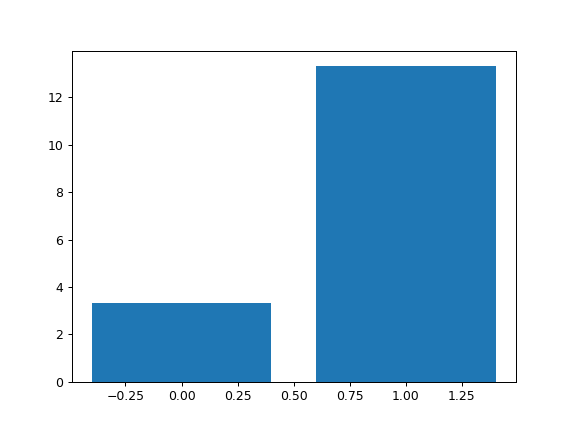

 the percentage of strokes with 1 is 13.303769401330376%.
 the percentage of strokes with 0 is 3.342305966801256%.
the percentage difference is 9.96146343452912%.
---------------------------------------------------------------------------------------------------------
heart_disease


<IPython.core.display.Javascript object>


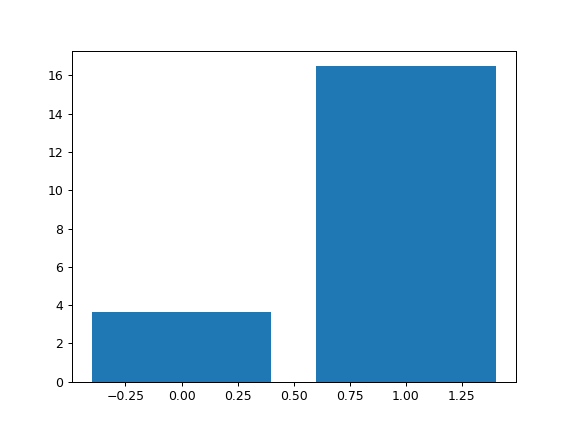

 the percentage of strokes with 1 is 16.46090534979424%.
 the percentage of strokes with 0 is 3.621945992284612%.
the percentage difference is 12.838959357509626%.
---------------------------------------------------------------------------------------------------------
ever_married


<IPython.core.display.Javascript object>


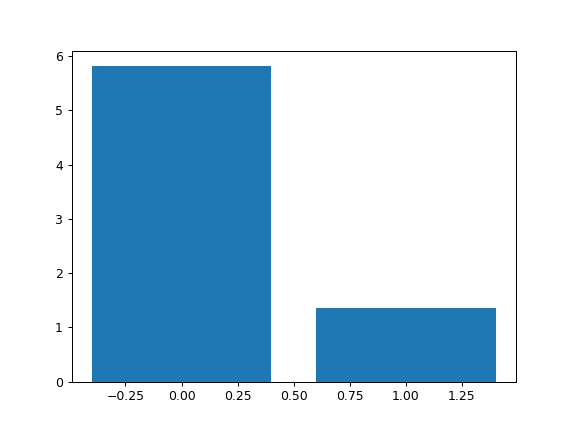

 the percentage of strokes with 1 is 1.3489736070381233%.
 the percentage of strokes with 0 is 5.805243445692884%.
the percentage difference is -4.456269838654761%.
---------------------------------------------------------------------------------------------------------
Residence_type


<IPython.core.display.Javascript object>


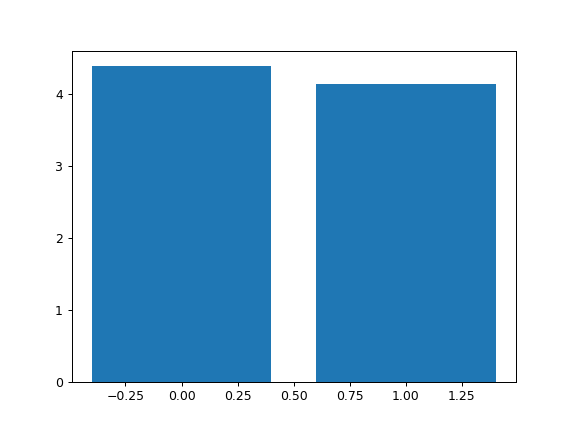

 the percentage of strokes with 1 is 4.13393964448119%.
 the percentage of strokes with 0 is 4.377510040160643%.
the percentage difference is -0.24357039567945282%.
---------------------------------------------------------------------------------------------------------
Male


<IPython.core.display.Javascript object>


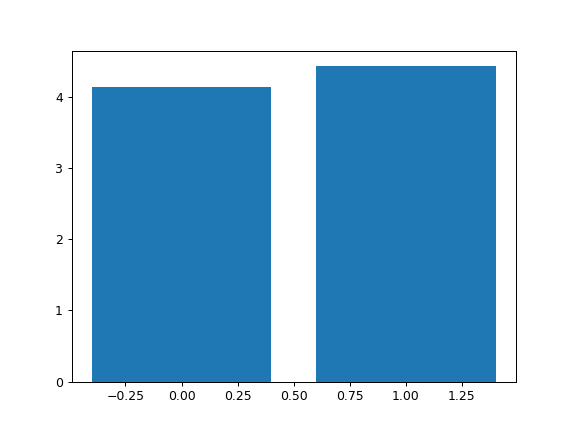

 the percentage of strokes with 1 is 4.4256588761810045%.
 the percentage of strokes with 0 is 4.140786749482402%.
the percentage difference is 0.28487212669860273%.
---------------------------------------------------------------------------------------------------------
Female


<IPython.core.display.Javascript object>


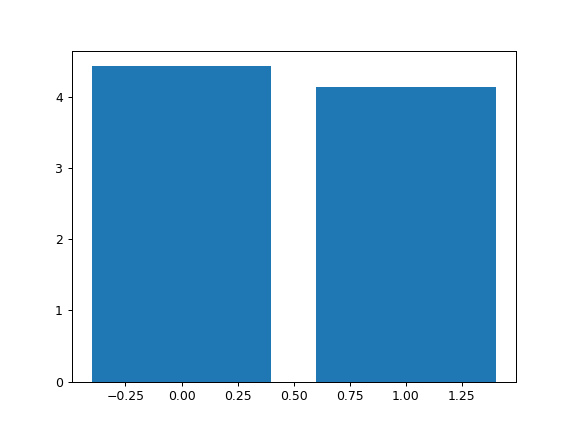

 the percentage of strokes with 1 is 4.142216085605799%.
 the percentage of strokes with 0 is 4.423459244532803%.
the percentage difference is -0.2812431589270039%.
---------------------------------------------------------------------------------------------------------
Govt_job


<IPython.core.display.Javascript object>


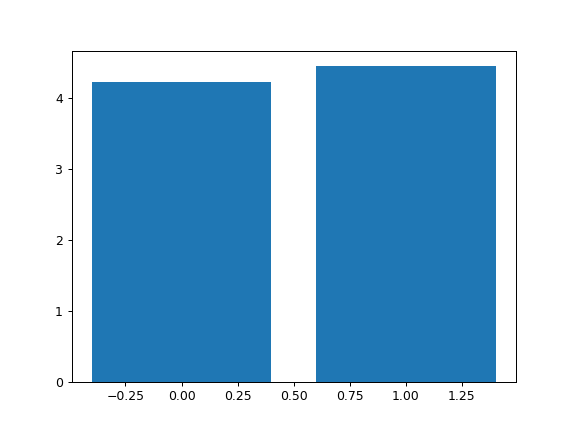

 the percentage of strokes with 1 is 4.444444444444445%.
 the percentage of strokes with 0 is 4.229960271091376%.
the percentage difference is 0.21448417335306846%.
---------------------------------------------------------------------------------------------------------
Never_worked


<IPython.core.display.Javascript object>


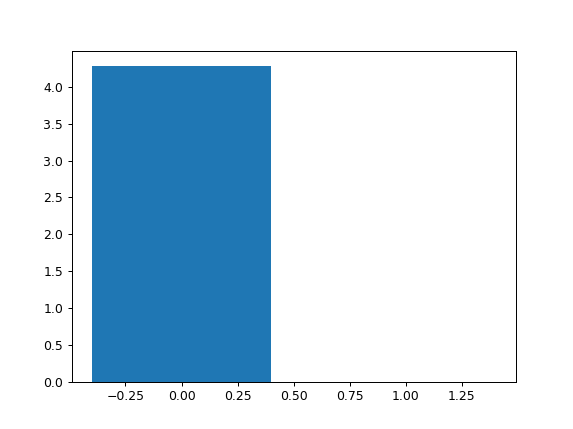

 the percentage of strokes with 1 is 0.0%.
 the percentage of strokes with 0 is 4.276652342950685%.
the percentage difference is -4.276652342950685%.
---------------------------------------------------------------------------------------------------------
children


<IPython.core.display.Javascript object>


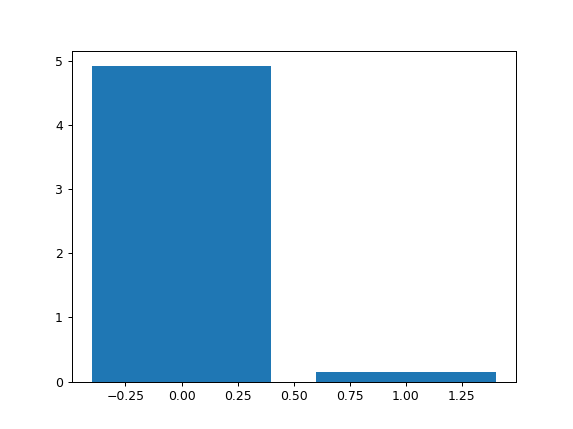

 the percentage of strokes with 1 is 0.14903129657228018%.
 the percentage of strokes with 0 is 4.9079754601226995%.
the percentage difference is -4.758944163550419%.
---------------------------------------------------------------------------------------------------------
Self-employed


<IPython.core.display.Javascript object>


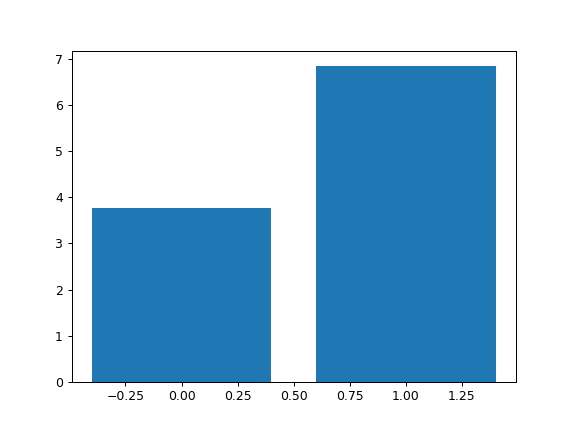

 the percentage of strokes with 1 is 6.838709677419355%.
 the percentage of strokes with 0 is 3.7735849056603774%.
the percentage difference is 3.0651247717589776%.
---------------------------------------------------------------------------------------------------------
Private


<IPython.core.display.Javascript object>


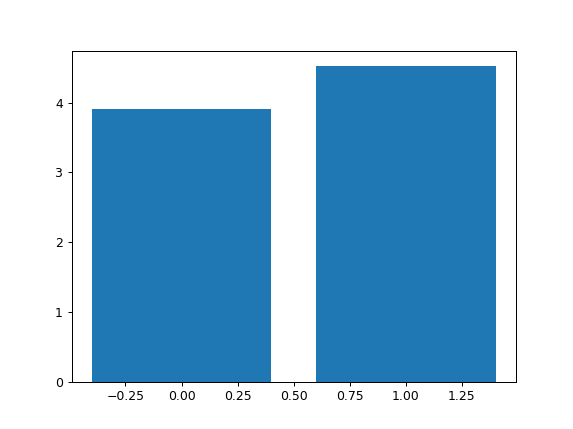

 the percentage of strokes with 1 is 4.517965136961935%.
 the percentage of strokes with 0 is 3.9084842707340326%.
the percentage difference is 0.6094808662279028%.
---------------------------------------------------------------------------------------------------------
['Never_worked', 'children', 'Self-employed', 'Residence_type', 'Male', 'Female', 'Govt_job', 'Private']


In [16]:
# run 2nd stage data preprocessing by coorolation with stroke chance

data = pd.read_csv('data/preprocessed-healthcare-dataset-stroke-data.csv')

# get all keys from datasheet
bols = []
for key in data.columns:
    bols.append(key)

# remove non-bools manually, possible for small data set
bols.remove('age')
bols.remove('avg_glucose_level')
bols.remove('bmi')
bols.remove('stroke')
bols.remove('smoking_status')

# manually set non-bool keys acceptable for small column list
nbols = ['age','avg_glucose_level','bmi']

# innitialse class
preplots = preplotter(data)

remove_list = ['Never_worked', 'children', 'Self-employed']

# look over bool variables
for name in bols:
    print(name)
    # return difference in percentage stroke, if there is coorolation there would be a significant difference in stroke
    # amounts between the boolean anwsers
    dv = preplots.histogram(name)
    print('---------------------------------------------------------------------------------------------------------')
    # remove data that has similar stroke percentage i.e. non-predictive of stroke chances
    if abs(dv) < 1.1 : #ARBITRARY VALUE SET
        remove_list.append(name)

print(remove_list)

# initalize preprocessor class agaon
data_p = Preprocessor(data.copy())
# remove 2nd wave of non-predictive data
for name in remove_list:
    data_p.remove(name)
       
# save to new file
data_p.data.to_csv('data/preprocessed-healthcare-dataset-stroke-data.csv', index=False)


We use the plotter class to check to see if the non-boolean data is correlated.

age


<IPython.core.display.Javascript object>


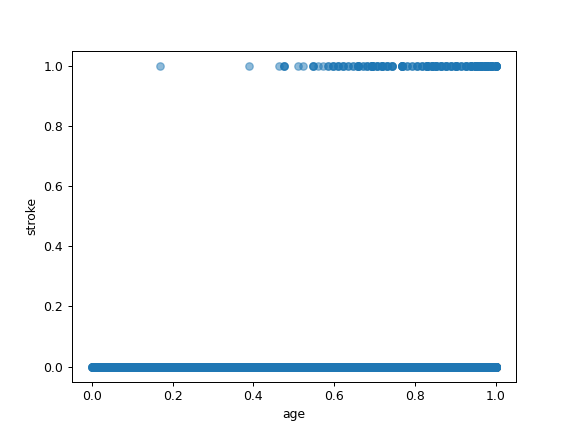

avg_glucose_level


<IPython.core.display.Javascript object>


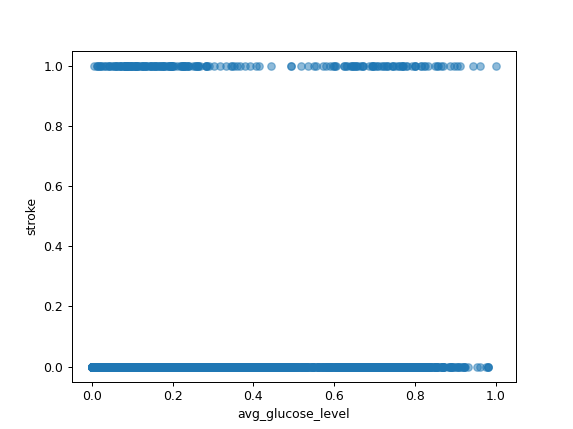

bmi


<IPython.core.display.Javascript object>


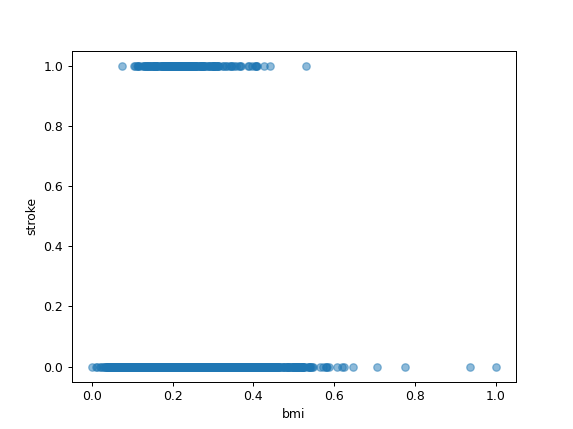

In [17]:
# print scatter graphs for each non-boolean function to check for corrolation
for name in nbols:
    print(name)
    preplots.scatter(name, 'stroke')

<IPython.core.display.Javascript object>


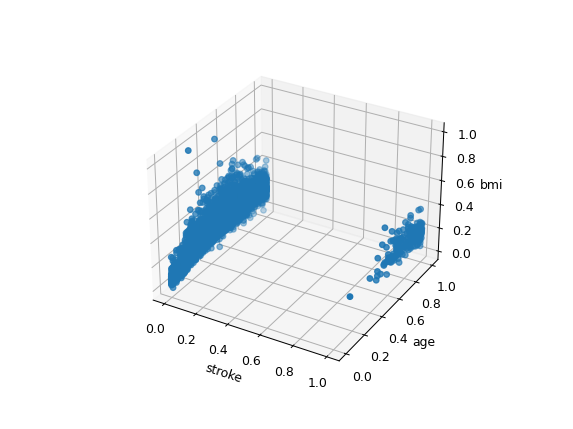

In [18]:
# visualise data in 3D
preplots.scatter('stroke','age','bmi')

# Column removal

Here we removed columns from the preprocessed data, in preperation for the final notebook where the effects will be compared.

In [13]:
# read preprocessed data to delete columns to used in the final cell, hence output to csv

# load preporcessed data
data = pd.read_csv('data/preprocessed-healthcare-dataset-stroke-data.csv')

# run loop over names
for name in data.columns:
    
    # generate class using copy of data so it can be reused in loop
    datap = Preprocessor(data.copy())
    # remove specific data column
    datare = datap.remove(name)
    # output to csv in diff file 
    datare.to_csv(f'data/data_removed/{name}_removed-healthcare-dataset-stroke-data.csv',)
data

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,stroke
0,0.816895,0,1,0,0.801265,0.301260,0,1
1,0.975586,0,1,0,0.234512,0.254296,3,1
2,0.597168,0,0,0,0.536008,0.276060,1,1
3,0.963379,1,0,0,0.549349,0.156930,3,1
4,0.987793,0,0,0,0.605161,0.214204,0,1
...,...,...,...,...,...,...,...,...
4904,0.157715,0,0,1,0.221402,0.095074,2,0
4905,0.987793,0,0,0,0.323516,0.340206,3,0
4906,0.426270,0,0,0,0.128658,0.232532,3,0
4907,0.621582,0,0,0,0.513203,0.175258,0,0


# Implementing the classifier
In this section, we decide which of the classifiers to use and how to split our data 



## The regressor class
This class is initialised with any sci kit learn regressor/classifier object, any sci kit cross validation object and a csv file with the data. It fits the regressor with data split using the cross validator and stores the resulting y_pred, X_test and y_test values. 



In [19]:
def load(fname: str, cv: str) -> tuple:
    """Loads data from a CSV file and splits it using scikit"""

    # read data
    data = pd.read_csv(fname)
    y_column = 'stroke'
    X_columns = list(data.columns)
    X_columns.remove(y_column)
    X = data[X_columns].to_numpy()
    y = data[y_column].to_numpy()

    # splitting calling the scikit split method of each cross validator
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    # return all
    return X, y, X_train, y_train, X_test, y_test

class Regressor:
    """Container for analysing different metrics for a single regression class"""
    def __init__(self, cls, fname: str, cv, cls_kwargs: dict = {}, cv_kwargs: dict = {} ):
        # construct regressor object
        self.regressor = cls(**cls_kwargs)
        self.cv = cv(**cv_kwargs)

        # use load function
        # where cv is a splitting class i.e kFold()
        self.X, self.y, self.X_train, self.y_train, self.X_test, self.y_test = load(fname, self.cv)

        # fit data
        self.regressor.fit(self.X_train, self.y_train)

        # get predicted data
        self.y_pred = self.regressor.predict(self.X_test)

    def metric(self, cls, **kwargs) -> float:
        """Takes a sklearn.metrics class and returns the score of the regressor object"""

        # use the metric class to get a score
        return cls(self.y_test, self.y_pred)
    
        # method that predicts new y values from new x data
    def predict(self, newdata):
        y = self.regressor.predict(newdata)
        return y

## The Postplotter class
This class has the plots we want to make after regressing the data, currently it has just the confusion matrix.

In [20]:
class postplotter:
    
    #initalise self with regressor object and test data
    def __init__ (self, x_test, y_test, y_pred):
        self.y_test = y_test
        self.y_pred = y_pred
        self.x_test = x_test
        
    # plots confusion matrix and gives FR values
        
    def confmatrix (self):
    
        fig, ax = plt.subplots()
        array = np.zeros((2, 2))

        for i, correct_value in enumerate(self.y_test):
            predicted_value = int(abs(np.round(self.y_pred[i])))
            array[predicted_value, correct_value] += 1

        # print dataframe represenation of array
        print(pd.DataFrame(array))

        # plot array as image
        im = ax.imshow(array, origin='lower', cmap='viridis')

        # label axes
        ax.set_xlabel('Real Type')
        ax.set_ylabel('Predicted Type')

        # add colorbar
        plt.colorbar(im)
        
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        
        for i in range(2):
            for j in range(2):

                # leave colour as white as the default
                color = 'black'
                if (i == 2 and j != 2):

                    # when overdose happened but wasn't predicted, changed colour
                    # to red if it is not 0
                    if array[i, j] == 0:
                        color = 'black'

                    else:
                        color = 'black'

                # set colour to black for the light coloured square
                # this is done after plotting once
                elif i == 1 and j == 1:
                    color = 'black'

                # add text with correct colour
                ax.text(j, i, array[i, j], ha='center', va='center', color=color)
        

        
        #calculates F1, P and R values
        P = (array[1,1]/(array[1,1]+array[0,1]))*100
        R = (array[1,1]/(array[1,1]+array[1,0]))*100
        F1 = 2*P*R/(P+R)

        print(f'Precision is:\n\n{P:2f}%\n')
        print(f'recall is:\n\n{R:2f}%\n')
        print(f'F-score is:\n\n{F1:2f}%\n')

## Accuracy issue 
When using the regressor on the entire data sets, classifiers found the best fit to predict 100% of the data to not have a stroke. The way we resolved this issue is by making the regressor run on a sample of the data where we use all the data on strokes and an equal amount of data for non strokes. This is justified below as we checked how this method performed across all the non-stroke data in 22 intervals of 210.

Iteration: 1


<IPython.core.display.Javascript object>


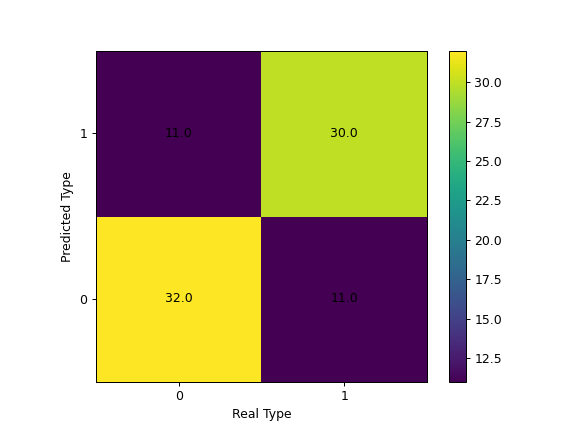

      0     1
0  32.0  11.0
1  11.0  30.0
Precision is:

73.170732%

recall is:

73.170732%

F-score is:

73.170732%

0.7380952380952381
-----------------------------------------------------------


Iteration: 2


<IPython.core.display.Javascript object>


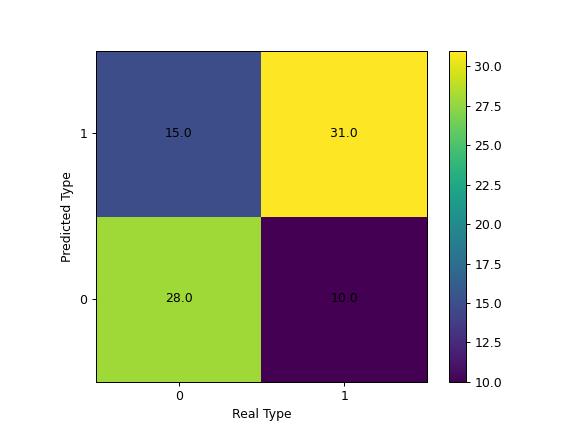

      0     1
0  28.0  10.0
1  15.0  31.0
Precision is:

75.609756%

recall is:

67.391304%

F-score is:

71.264368%

0.7023809523809523
-----------------------------------------------------------


Iteration: 3


<IPython.core.display.Javascript object>


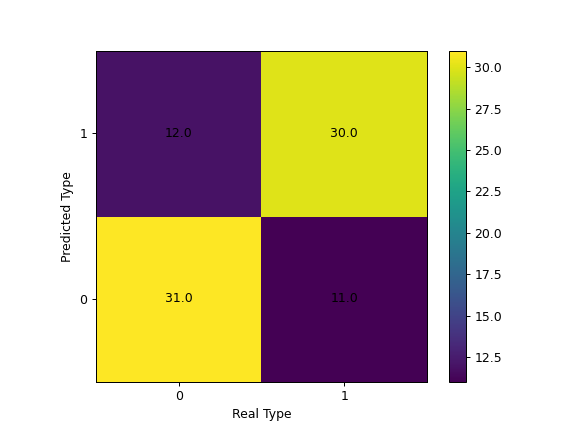

      0     1
0  31.0  11.0
1  12.0  30.0
Precision is:

73.170732%

recall is:

71.428571%

F-score is:

72.289157%

0.7261904761904762
-----------------------------------------------------------


Iteration: 4


<IPython.core.display.Javascript object>


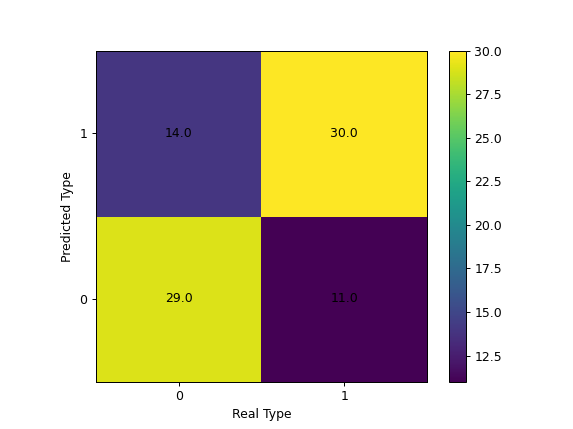

      0     1
0  29.0  11.0
1  14.0  30.0
Precision is:

73.170732%

recall is:

68.181818%

F-score is:

70.588235%

0.7023809523809523
-----------------------------------------------------------


Iteration: 5


<IPython.core.display.Javascript object>


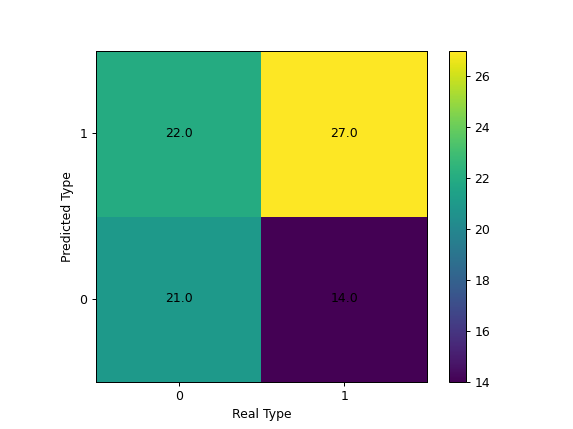

      0     1
0  21.0  14.0
1  22.0  27.0
Precision is:

65.853659%

recall is:

55.102041%

F-score is:

60.000000%

0.5714285714285714
-----------------------------------------------------------


Iteration: 6


<IPython.core.display.Javascript object>


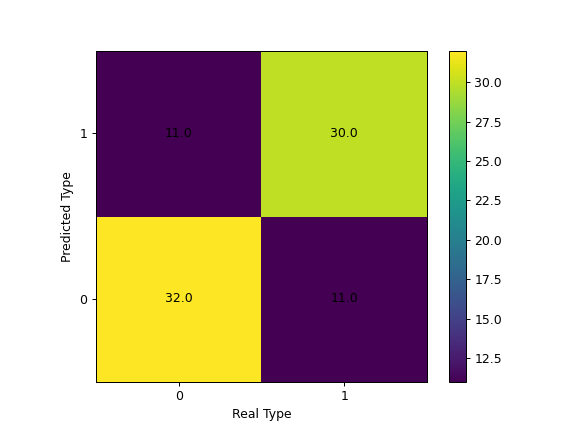

      0     1
0  32.0  11.0
1  11.0  30.0
Precision is:

73.170732%

recall is:

73.170732%

F-score is:

73.170732%

0.7380952380952381
-----------------------------------------------------------


Iteration: 7


<IPython.core.display.Javascript object>


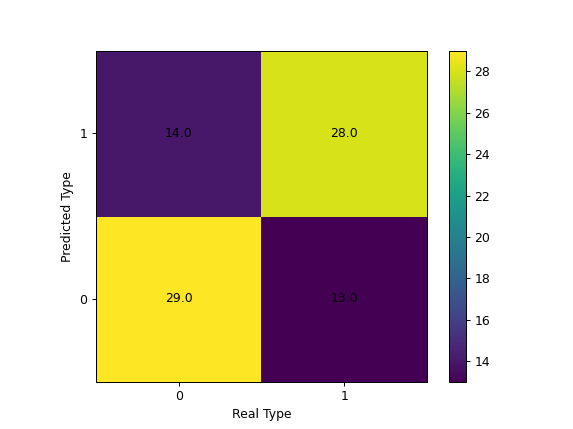

      0     1
0  29.0  13.0
1  14.0  28.0
Precision is:

68.292683%

recall is:

66.666667%

F-score is:

67.469880%

0.6785714285714286
-----------------------------------------------------------


Iteration: 8


<IPython.core.display.Javascript object>


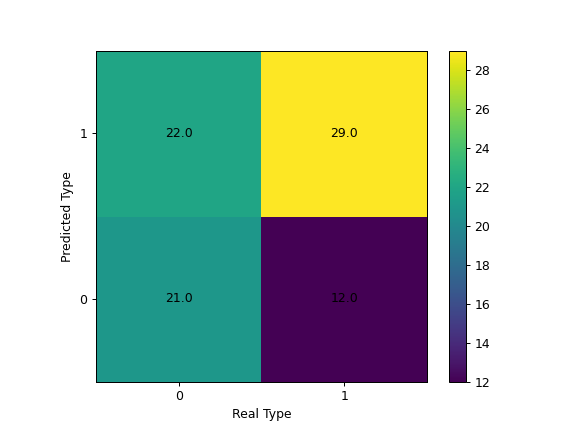

      0     1
0  21.0  12.0
1  22.0  29.0
Precision is:

70.731707%

recall is:

56.862745%

F-score is:

63.043478%

0.5952380952380952
-----------------------------------------------------------


Iteration: 9


<IPython.core.display.Javascript object>


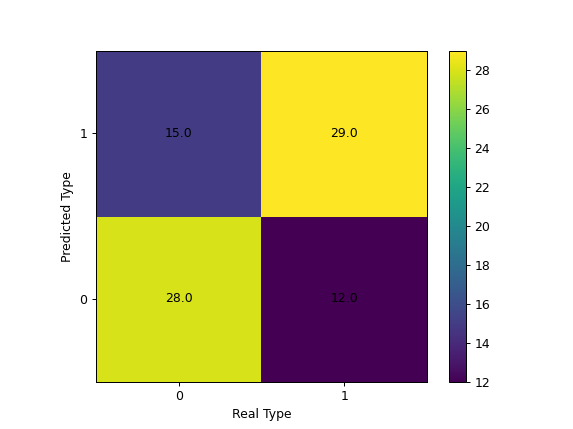

      0     1
0  28.0  12.0
1  15.0  29.0
Precision is:

70.731707%

recall is:

65.909091%

F-score is:

68.235294%

0.6785714285714286
-----------------------------------------------------------


Iteration: 10


<IPython.core.display.Javascript object>


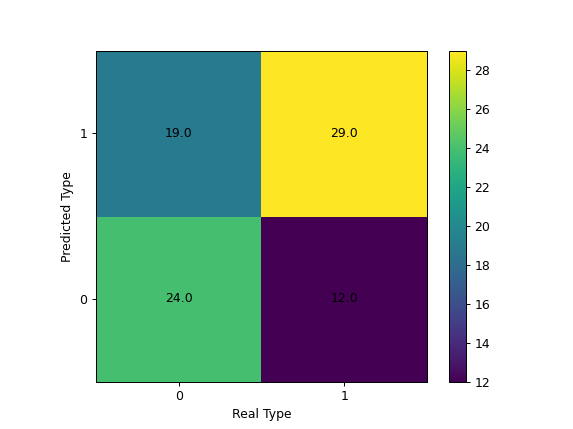

      0     1
0  24.0  12.0
1  19.0  29.0
Precision is:

70.731707%

recall is:

60.416667%

F-score is:

65.168539%

0.6309523809523809
-----------------------------------------------------------


Iteration: 11


<IPython.core.display.Javascript object>


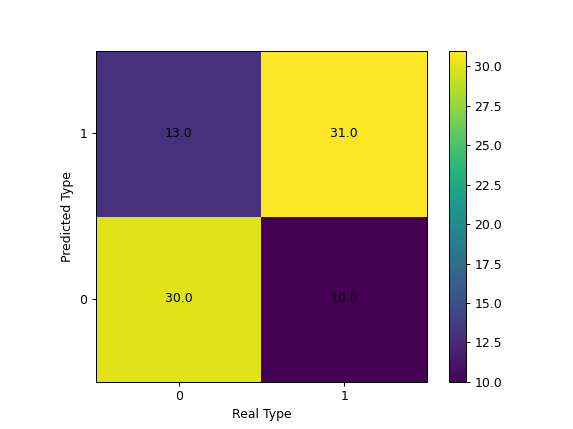

      0     1
0  30.0  10.0
1  13.0  31.0
Precision is:

75.609756%

recall is:

70.454545%

F-score is:

72.941176%

0.7261904761904762
-----------------------------------------------------------


Iteration: 12


<IPython.core.display.Javascript object>


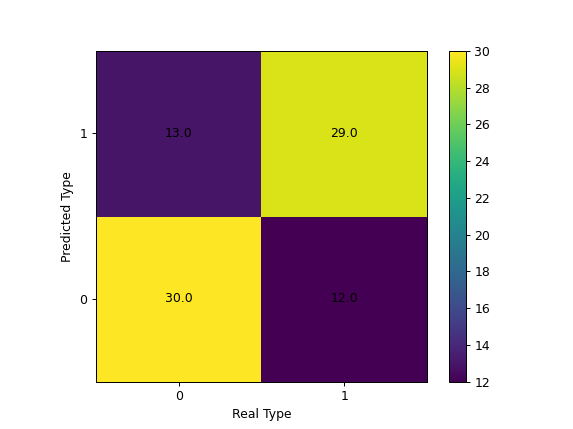

      0     1
0  30.0  12.0
1  13.0  29.0
Precision is:

70.731707%

recall is:

69.047619%

F-score is:

69.879518%

0.7023809523809523
-----------------------------------------------------------


Iteration: 13


<IPython.core.display.Javascript object>


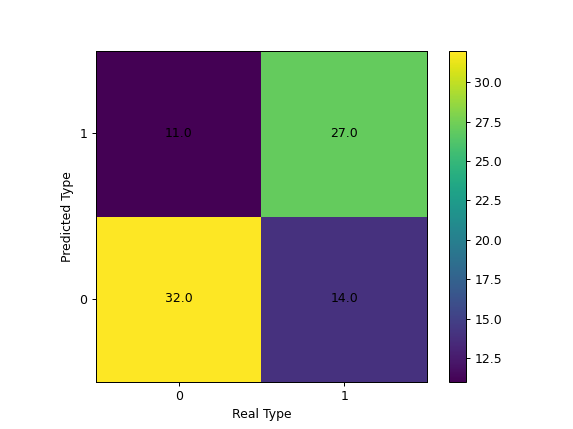

      0     1
0  32.0  14.0
1  11.0  27.0
Precision is:

65.853659%

recall is:

71.052632%

F-score is:

68.354430%

0.7023809523809523
-----------------------------------------------------------


Iteration: 14


<IPython.core.display.Javascript object>


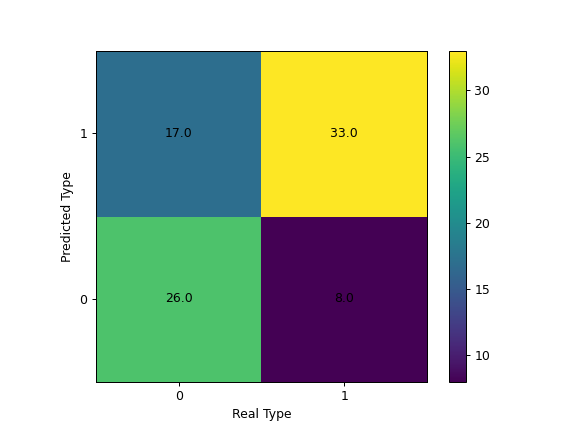

      0     1
0  26.0   8.0
1  17.0  33.0
Precision is:

80.487805%

recall is:

66.000000%

F-score is:

72.527473%

0.7023809523809523
-----------------------------------------------------------


Iteration: 15


<IPython.core.display.Javascript object>


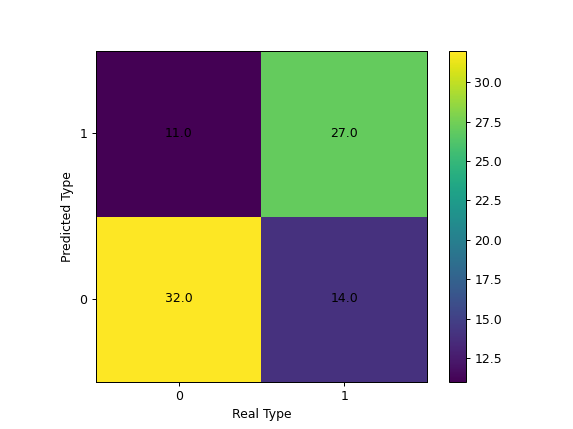

      0     1
0  32.0  14.0
1  11.0  27.0
Precision is:

65.853659%

recall is:

71.052632%

F-score is:

68.354430%

0.7023809523809523
-----------------------------------------------------------


Iteration: 16


<IPython.core.display.Javascript object>


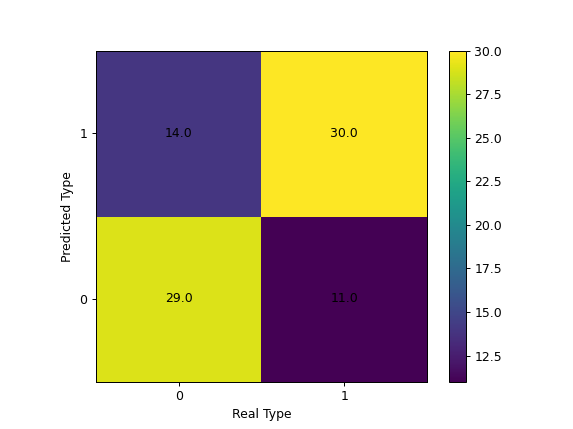

      0     1
0  29.0  11.0
1  14.0  30.0
Precision is:

73.170732%

recall is:

68.181818%

F-score is:

70.588235%

0.7023809523809523
-----------------------------------------------------------


Iteration: 17


<IPython.core.display.Javascript object>


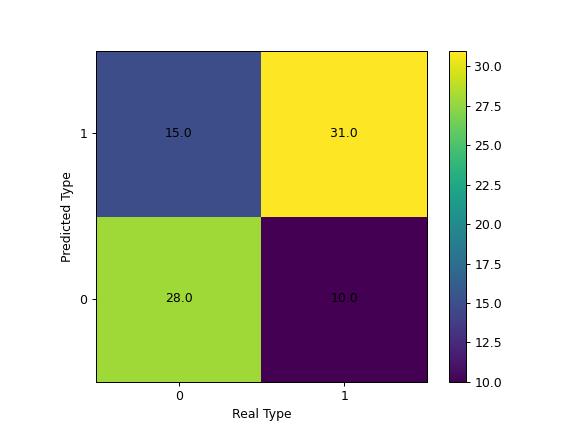

      0     1
0  28.0  10.0
1  15.0  31.0
Precision is:

75.609756%

recall is:

67.391304%

F-score is:

71.264368%

0.7023809523809523
-----------------------------------------------------------


Iteration: 18


<IPython.core.display.Javascript object>


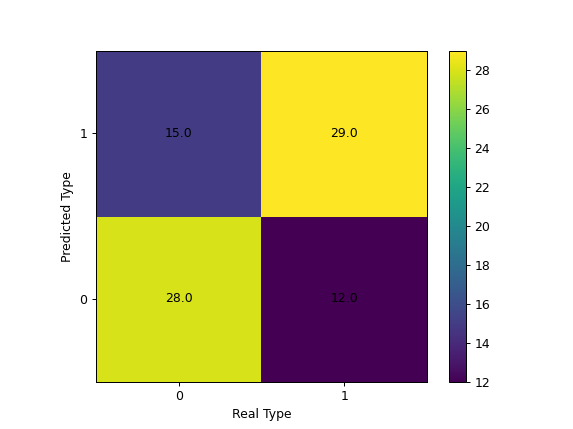

      0     1
0  28.0  12.0
1  15.0  29.0
Precision is:

70.731707%

recall is:

65.909091%

F-score is:

68.235294%

0.6785714285714286
-----------------------------------------------------------


Iteration: 19


<IPython.core.display.Javascript object>


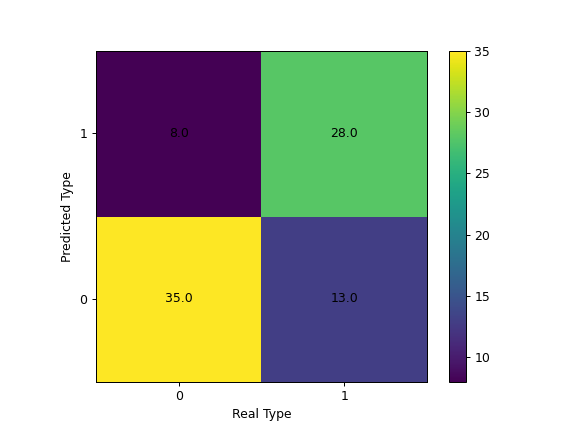

      0     1
0  35.0  13.0
1   8.0  28.0
Precision is:

68.292683%

recall is:

77.777778%

F-score is:

72.727273%

0.75
-----------------------------------------------------------


Iteration: 20


<IPython.core.display.Javascript object>


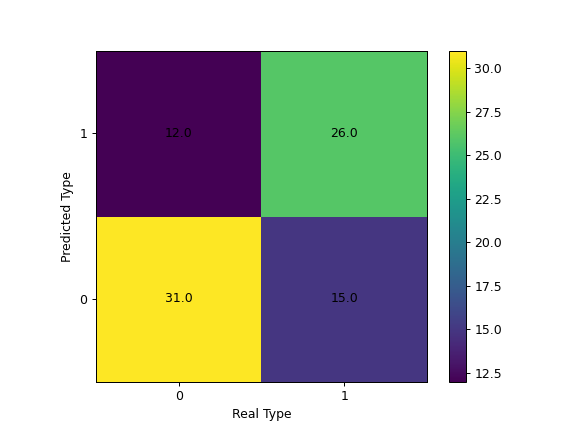

      0     1
0  31.0  15.0
1  12.0  26.0
Precision is:

63.414634%

recall is:

68.421053%

F-score is:

65.822785%

0.6785714285714286
-----------------------------------------------------------


Iteration: 21


<ipython-input-20-5e01219ea090>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<IPython.core.display.Javascript object>


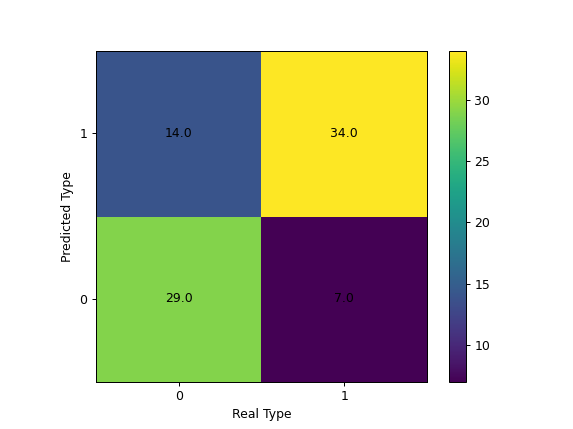

      0     1
0  29.0   7.0
1  14.0  34.0
Precision is:

82.926829%

recall is:

70.833333%

F-score is:

76.404494%

0.75
-----------------------------------------------------------




In [23]:
#trying the KNeighbours classifier to justify using small amounts of the data to train the classifier 
daata = pd.read_csv('data/preprocessed2-healthcare-dataset-stroke-data.csv')
strdata = daata.iloc[:210, :]
for n in range(1,22):
    rnddata = daata.iloc[210+n*210:210+(n+1)*210,:]
    concat = strdata.append(rnddata)  
    concat.to_csv(f'data/splits/split{n}.csv', index = False)
    rg = Regressor(KNeighborsClassifier, f'data/splits/split{n}.csv', StratifiedKFold)
    a = postplotter(rg.X_test, rg.y_test, rg.y_pred)
    print(f'Iteration: {n}')
    a.confmatrix()
    print(f'{rg.regressor.score(rg.X_test, rg.y_test)}\n-----------------------------------------------------------\n\n')

## Which classifier and which splitting method to use?
In this cell we looped our regressor class over different CV and regression objects from scikit learn and compared the best F-scores to determine which we would use for our data. 

In the end we decided it is best to use stratified Kfold so an even amount of the stroke data and non stroke data is used to fit the model. 

Once we decided to use these, the predicitivity was further analysed in notebook 2

In [24]:
#borrowed from the scikit learn documentation to visualise the different splitting techniques
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class', 'group']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

regressor:LogisticRegression(), splitting:ShuffleSplit(n_splits=10, random_state=None, test_size=None, train_size=None)


<IPython.core.display.Javascript object>


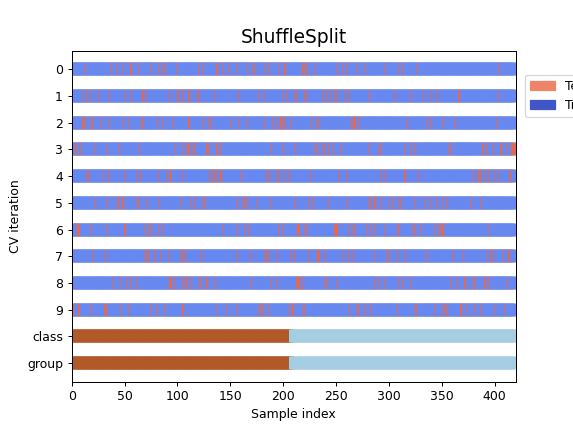

<IPython.core.display.Javascript object>


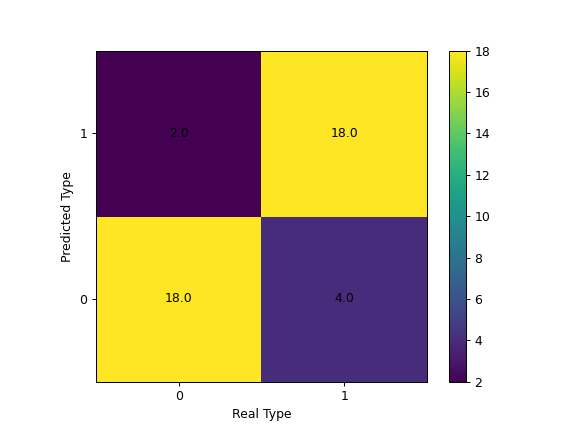

      0     1
0  18.0   4.0
1   2.0  18.0
Precision is:

81.818182%

recall is:

90.000000%

F-score is:

85.714286%

regressor:LogisticRegression(), splitting:StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


<IPython.core.display.Javascript object>


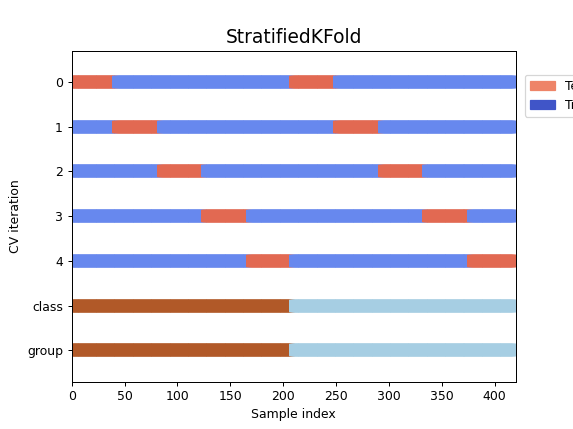

<IPython.core.display.Javascript object>


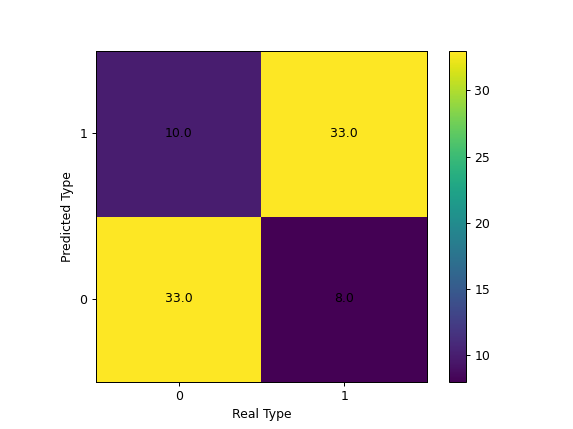

      0     1
0  33.0   8.0
1  10.0  33.0
Precision is:

80.487805%

recall is:

76.744186%

F-score is:

78.571429%

regressor:LogisticRegression(), splitting:KFold(n_splits=5, random_state=None, shuffle=False)


<IPython.core.display.Javascript object>


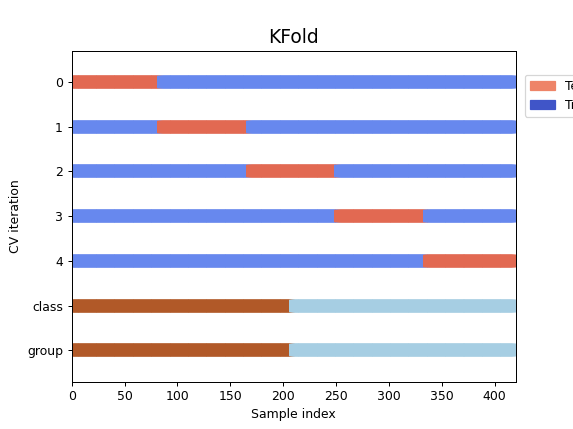

<IPython.core.display.Javascript object>


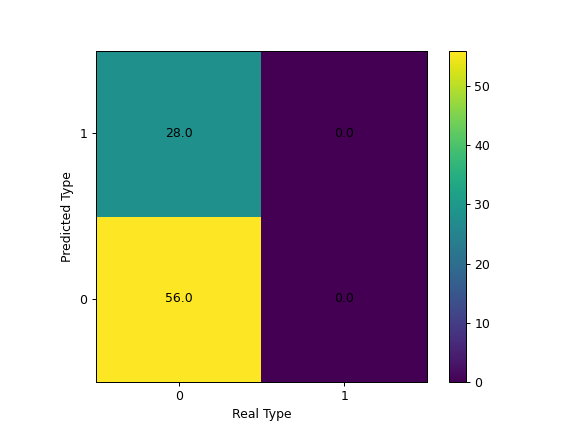

      0    1
0  56.0  0.0
1  28.0  0.0
Precision is:

nan%

recall is:

0.000000%

F-score is:

nan%

regressor:LogisticRegression(), splitting:StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=None,
            train_size=None)


<ipython-input-20-5e01219ea090>:62: RuntimeWarning: invalid value encountered in double_scalars
  P = (array[1,1]/(array[1,1]+array[0,1]))*100


<IPython.core.display.Javascript object>


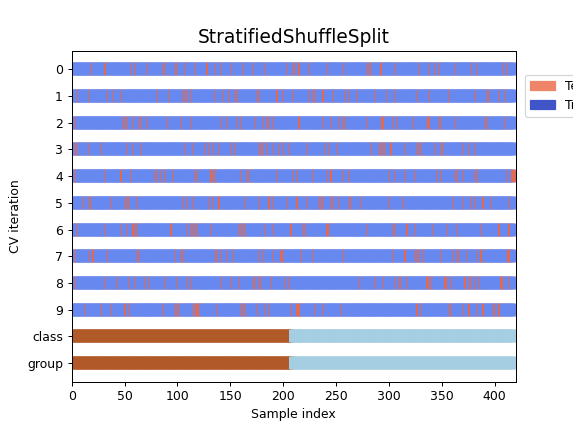

<IPython.core.display.Javascript object>


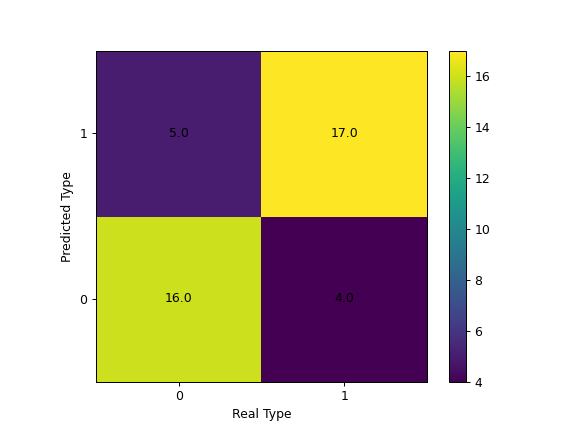

      0     1
0  16.0   4.0
1   5.0  17.0
Precision is:

80.952381%

recall is:

77.272727%

F-score is:

79.069767%

regressor:KNeighborsClassifier(), splitting:ShuffleSplit(n_splits=10, random_state=None, test_size=None, train_size=None)


<IPython.core.display.Javascript object>


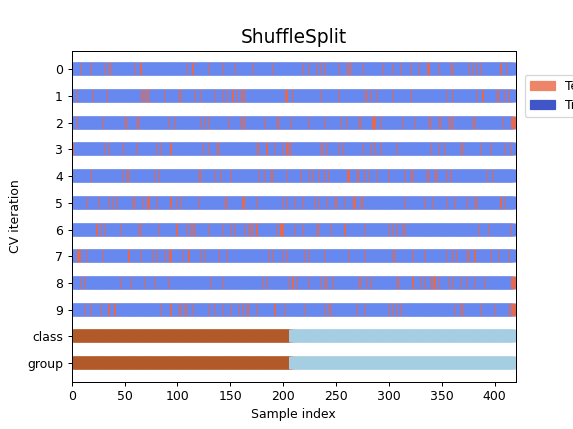

<IPython.core.display.Javascript object>


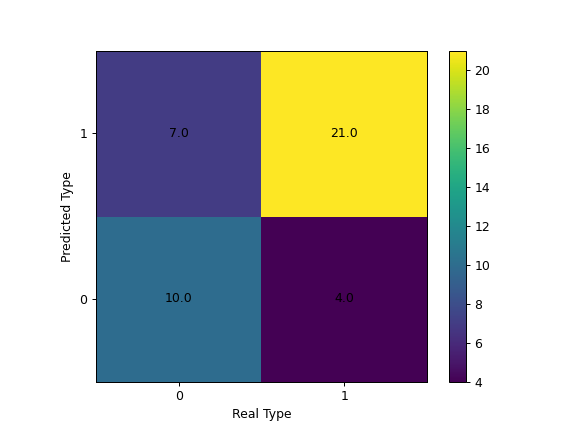

      0     1
0  10.0   4.0
1   7.0  21.0
Precision is:

84.000000%

recall is:

75.000000%

F-score is:

79.245283%

regressor:KNeighborsClassifier(), splitting:StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


<IPython.core.display.Javascript object>


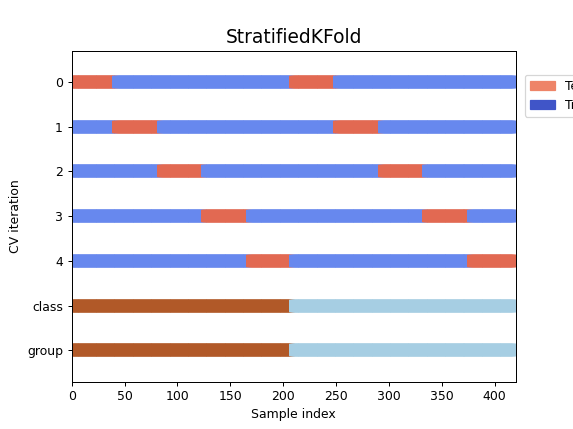

<IPython.core.display.Javascript object>


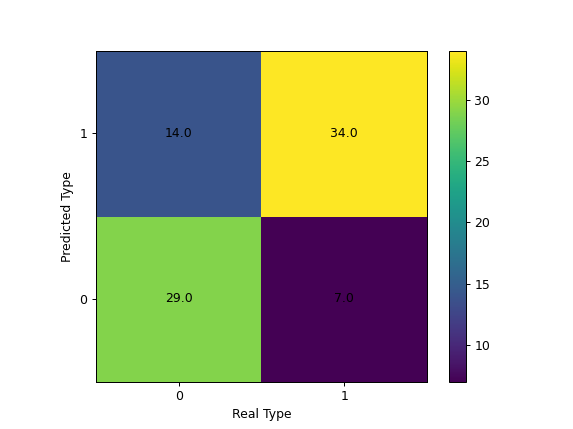

      0     1
0  29.0   7.0
1  14.0  34.0
Precision is:

82.926829%

recall is:

70.833333%

F-score is:

76.404494%

regressor:KNeighborsClassifier(), splitting:KFold(n_splits=5, random_state=None, shuffle=False)


<IPython.core.display.Javascript object>


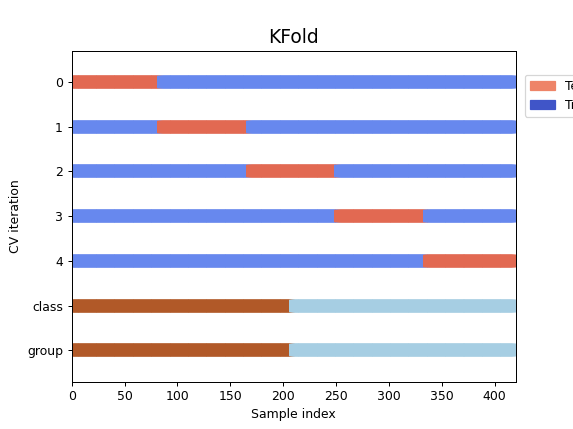

<IPython.core.display.Javascript object>


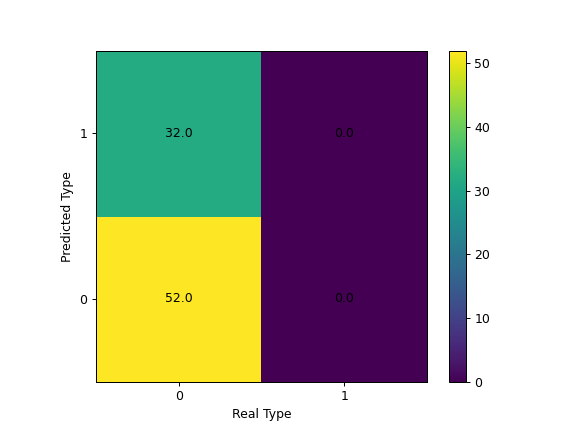

      0    1
0  52.0  0.0
1  32.0  0.0
Precision is:

nan%

recall is:

0.000000%

F-score is:

nan%

regressor:KNeighborsClassifier(), splitting:StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=None,
            train_size=None)


<ipython-input-20-5e01219ea090>:62: RuntimeWarning: invalid value encountered in double_scalars
  P = (array[1,1]/(array[1,1]+array[0,1]))*100


<IPython.core.display.Javascript object>


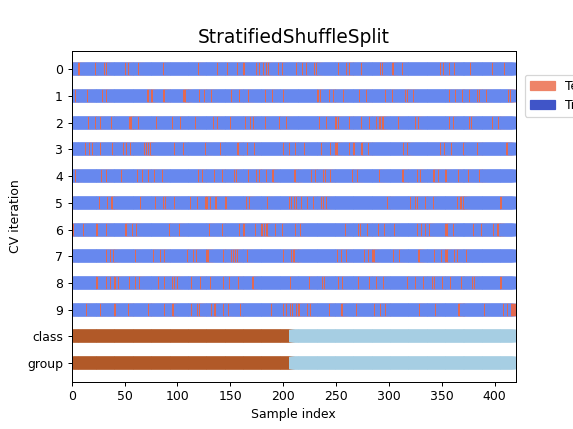

<IPython.core.display.Javascript object>


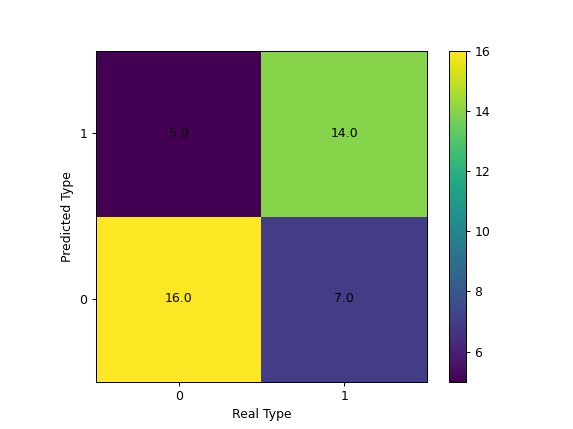

      0     1
0  16.0   7.0
1   5.0  14.0
Precision is:

66.666667%

recall is:

73.684211%

F-score is:

70.000000%

regressor:RandomForestRegressor(), splitting:ShuffleSplit(n_splits=10, random_state=None, test_size=None, train_size=None)


<IPython.core.display.Javascript object>


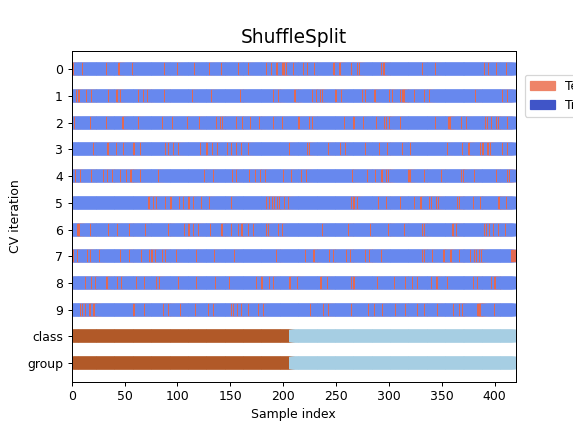

<IPython.core.display.Javascript object>


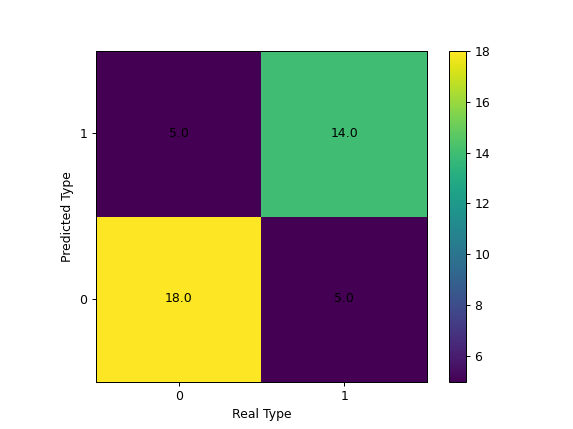

      0     1
0  18.0   5.0
1   5.0  14.0
Precision is:

73.684211%

recall is:

73.684211%

F-score is:

73.684211%

regressor:RandomForestRegressor(), splitting:StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


<IPython.core.display.Javascript object>


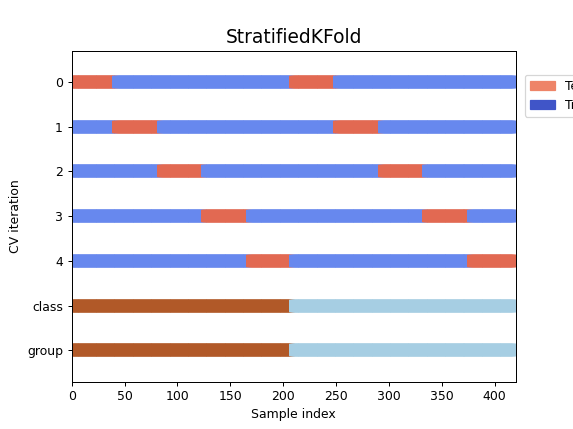

<IPython.core.display.Javascript object>


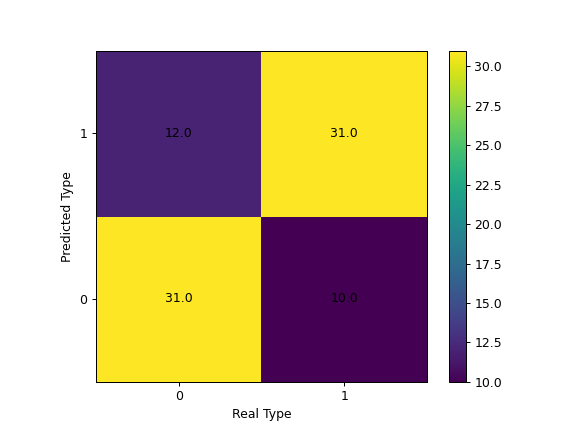

      0     1
0  31.0  10.0
1  12.0  31.0
Precision is:

75.609756%

recall is:

72.093023%

F-score is:

73.809524%

regressor:RandomForestRegressor(), splitting:KFold(n_splits=5, random_state=None, shuffle=False)


<IPython.core.display.Javascript object>


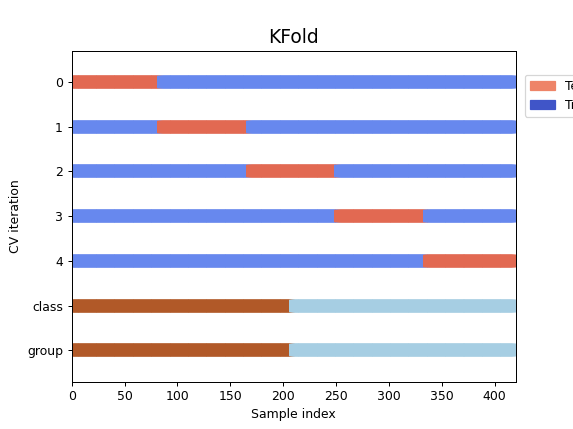

<IPython.core.display.Javascript object>


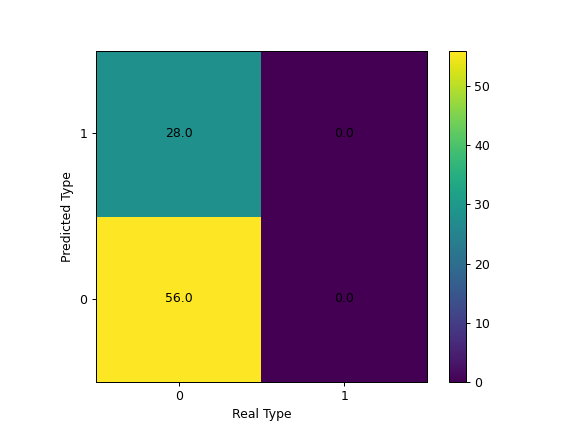

      0    1
0  56.0  0.0
1  28.0  0.0
Precision is:

nan%

recall is:

0.000000%

F-score is:

nan%

regressor:RandomForestRegressor(), splitting:StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=None,
            train_size=None)


<ipython-input-20-5e01219ea090>:62: RuntimeWarning: invalid value encountered in double_scalars
  P = (array[1,1]/(array[1,1]+array[0,1]))*100


<IPython.core.display.Javascript object>


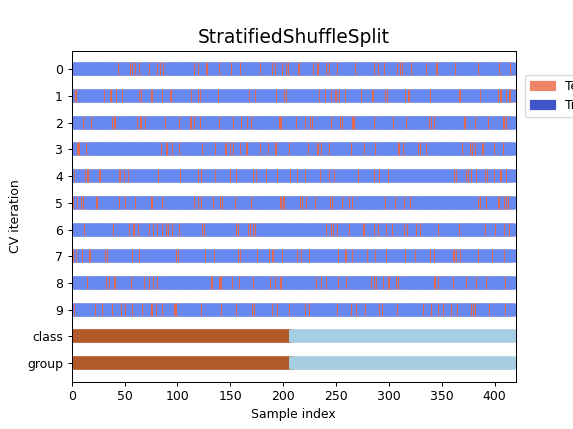

<IPython.core.display.Javascript object>


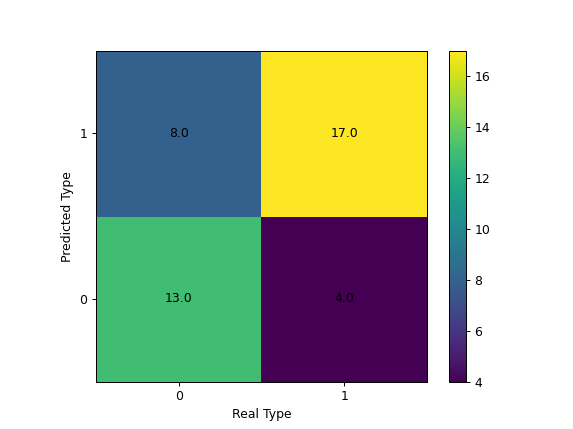

      0     1
0  13.0   4.0
1   8.0  17.0
Precision is:

80.952381%

recall is:

68.000000%

F-score is:

73.913043%



In [25]:
#Running different regressors with different splitting techniques and returns the confusion matrix in order
#to determine which ones to use for the data 
reg_list = [LogisticRegression, KNeighborsClassifier, RandomForestRegressor]
cv_list = [ShuffleSplit, StratifiedKFold, KFold, StratifiedShuffleSplit]
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
#DEFINE FNAME
fname = 'data/splits/split21.csv'
groups_ = data['stroke'].to_numpy()
for regressor in reg_list: 
    for cv in cv_list:
        print(f'regressor:{str(regressor())}, splitting:{str(cv())}')
        rg = Regressor(regressor, fname, cv)
        a = postplotter(rg.X_test, rg.y_test, rg.y_pred)
        fig, ax = plt.subplots()
        plot_cv_indices(rg.cv, rg.X, rg.y, rg.y, ax, rg.cv.get_n_splits() )
        ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
        a.confmatrix()
